# cosmo_derived

This plugin calculates the following "derived" cosmological quantities:
* $H(z)$
* $D_A(z)$
* $r_s(z)$
* $\theta_s(z)$
* $z_{\rm drag}$ (Hu & Sugiyama fitting formula)

It can also be used as a $\theta$ to $H_0$ converter.

Credit: Lloyd Knox, code adapted by Marius Millea

In [1]:
from cosmoslik import *

In [2]:
cosmo_derived = get_plugin('models.cosmo_derived')()

To use `cosmo_derived`, first call the `set_params` function to set all the cosmological parameters, then call the other functions which will subsequently use those values. Here's the signature for `set_params`:

In [3]:
help(cosmo_derived.set_params)

Help on built-in function set_params:

set_params(...) method of cosmoslik_plugins.models.cosmo_derived.cosmo_derived._cosmo_derived instance
    _cosmo_derived.set_params(self, H0=None, theta_mc=None, ombh2=None, omch2=None, omk=None, mnu=None, massive_neutrinos=None, massless_neutrinos=None, Tcmb=None, Yp=None, **kwargs)
    
    Args:
        H0 : hubble constant today in km/s/Mpc
        ombh2, omch2, omk : densities today
        mnu : neutrino mass sum in eV
        massive_neutrinos : number of massive species (mnu divided equally among them)
        massless_neutrinos : number of massless species
        Yp : helium mass fraction
        Tcmb : CMB temperature in Kelvin
        theta_mc : if given, will convert to H0 and set H0 to that



In [4]:
cosmo_derived.set_params(H0=67.04, ombh2=0.022032, omch2=0.12038, omk=0, mnu=0.06, massive_neutrinos=1, massless_neutrinos=2.046)

Plotting $H(z)$,

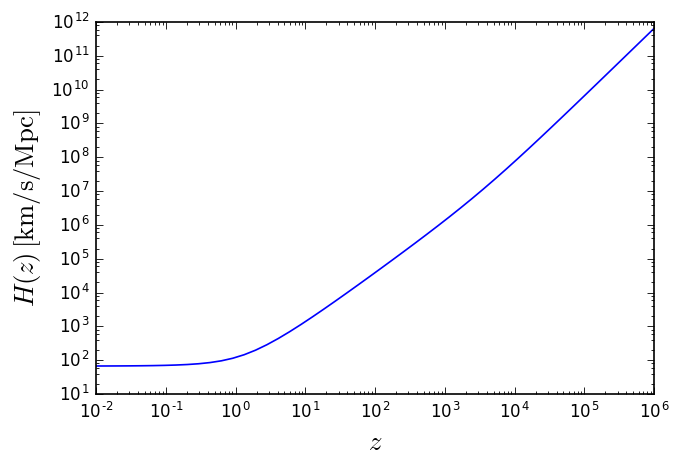

In [8]:
z=logspace(-2,6)
loglog(z,list(map(cosmo_derived.Hubble,z)))
xlabel(r'$z$',size=16)
ylabel(r'$H(z) \, [\rm km/s/Mpc]$',size=16);

Here's the angular size of sound horizon at Planck's best-fit $z_*$ (Table 2, Planck XVI). The number for $\theta_s$ in that same table is $0.0104136$, or a difference of $0.09 \sigma$. This is likely due to differences in numerical values for physical constants that were used, or numerical integration error.

In [9]:
z_star = 1090.48
cosmo_derived.theta_s(z_star)

0.010414141562032136

We can also use this plugin to convert $\theta$ to $H_0$. Here $\theta$ refers to $\theta_{\rm MC}$ which uses the Hu & Sugiyama fitting formula for $z_{\rm drag}$.

In [10]:
cosmo_derived.theta2hubble(0.0104)

66.95260969910498

This plugin is written in Cython and is highly optimizied, so its pretty fast.

In [11]:
%%timeit
cosmo_derived.theta_s(z_star)

100 loops, best of 3: 9.16 ms per loop


In [12]:
%%timeit
cosmo_derived.theta2hubble(0.0104)

10 loops, best of 3: 56 ms per loop


The $\theta_s$ calculation about 7 times slower than the equivalent Fortran code used in CosmoMC. The theta to hubble conversion is about 3 times **faster** than the CosmoMC version because the equation solver is more sophisticated and requires fewer $\theta_s$ evaluations. Not bad for being very readable and modifiable Cython code instead. As an example, here's what the code looks like:

```cython

    def r_s(self, double z):
        """
        Returns : comoving sound horizon scale at redshift z in Mpc.
        """
        cdef double Rovera=3*self.ombh2*rhoxOverOmegaxh2/(4*self.rhogamma0)
        return quad(lambda double zp: 1/self.Hubble(zp) / sqrt(3*(1+Rovera/(1+zp))),z,inf,epsabs=0,epsrel=self.epsrel)[0] / KmPerSOverC

```